## Training a sentiment analysis model with Chainer

In this notebook, we will train a model that will allow us to analyze text for positive or negative sentiment. The model will use a recurrent neural network with long short-term memory blocks to generate word embeddings.

The Chainer script runs inside of a Docker container running on SageMaker. For more on the Chainer container, please visit the sagemaker-chainer-containers repository and the sagemaker-python-sdk repository:

* https://github.com/aws/sagemaker-chainer-containers
* https://github.com/aws/sagemaker-python-sdk

In [1]:
# Setup
from sagemaker import get_execution_role
import sagemaker

sagemaker_session = sagemaker.Session()

# This role retrieves the SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

## Downloading training and test data

We use helper functions given by `chainer` to download and preprocess the data. We'll be using the [Stanford Sentiment Treebank dataset](https://nlp.stanford.edu/sentiment/), which consists of sentence fragments from movie reviews along with labels indicating whether the sentence has a positive sentiment (1) or negative sentiment (0).

In [2]:
import dataset

file_paths = dataset.download_dataset("stsa.binary")

new_file_paths = dataset.get_stsa_dataset(file_paths)
train, test, vocab = dataset.get_stsa_dataset(file_paths)

with open(file_paths[0], 'r') as f:
    for i in range(20):
        line = f.readline()
        print(line)

/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1 a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films

0 apparently reassembled from the cutting-room floor of any given daytime soap .

0 they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .

1 this is a visually stunning rumination on love , memory , history and the war between art and commerce .

1 jonathan parker 's bartleby should have been the be-all-end-all of the modern-office anomie films .

1 campanella gets the tone just right -- funny in the middle of sad in the middle of hopeful .

0 a fan film that for the uninitiated plays better on video with the sound turned down .

1 béart and berling are both superb , while huppert ... is magnificent .

0 a little less extreme than in the past , with longer exposition sequences between them , and with fewer gags 

## Uploading the data

We save the preprocessed data to the local filesystem, and then use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value `inputs` identifies the S3 location, which we will use when we start the Training Job.

In [3]:
import os
import shutil

import numpy as np

train_data = [element[0] for element in train]
train_labels = [element[1] for element in train]

test_data = [element[0] for element in test]
test_labels = [element[1] for element in test]


try:
    os.makedirs('/tmp/data/train_sentiment')
    os.makedirs('/tmp/data/test_sentiment')
    os.makedirs('/tmp/data/vocab')
    np.savez('/tmp/data/train_sentiment/train.npz', data=train_data, labels=train_labels)
    np.savez('/tmp/data/test_sentiment/test.npz', data=test_data, labels=test_labels)
    np.save('/tmp/data/vocab/vocab.npy', vocab)
    train_input = sagemaker_session.upload_data(path=os.path.join('/tmp', 'data', 'train_sentiment'),
                                                            key_prefix='notebook/chainer_sentiment/train')
    test_input = sagemaker_session.upload_data(path=os.path.join('/tmp', 'data', 'test_sentiment'),
                                                           key_prefix='notebook/chainer_sentiment/test')
    vocab_input = sagemaker_session.upload_data(path=os.path.join('/tmp', 'data', 'vocab'),
                                                           key_prefix='notebook/chainer_sentiment/vocab')
finally:
    shutil.rmtree('/tmp/data')

## Writing the Chainer training script to run on Amazon SageMaker

We need to provide a training script that can run on the SageMaker platform. The training scripts are essentially the same as one you would write for local training, except that you need to provide a function `train` that returns a trained `chainer.Chain`.

Since we will use the same script to host the Chainer model, the script also needs a function `model_fn` that loads a Chainer Model. When SageMaker calls your `train` and `model_fn` functions, it will pass in arguments that describe the training environment.

While the `train` and `model_fn` functions are required, the Chainer container provides default implementations for a few other functions. The function hooks recognized by the container are listed below, with required functions in bold:

### Training

* **`train`**: This function is passed arguments read from the Training Job's environment and returns a trained model. Files written to `model_dir` are compressed and uploaded to S3 at the end of training.
  `train` can accept the following arguments by name:
  * `hyperparameters (dict)`: The hyperparameters map passed from the SageMaker Python SDK.
  * `num_gpus (int)`: The number of GPUs available to the host.
  * `output_data_dir (str)`: The filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3.
  * `channel_input_dirs (dict of str: str)`: A map of input channel names (like 'train' and 'test') to filesystem paths to data in those input channels. 
  * `model_dir (str)`: path to the directory to write model artifacts to.
  
  For more on the arguments to `train` and others, please visit https://github.com/aws/sagemaker-containers.
  

### Hosting and Inference

* **`model_fn(model_dir)`**: This function is invoked to load model artifacts from those written into `model_dir` during training.
* `input_fn(input_data, content_type)`: This function is invoked to deserialize prediction data when a prediction request is made. The return value is passed to predict_fn. `input_fn` accepts two arguments: `input_data`, which is the serialized input data in the body of the prediction request, and `content_type`, the MIME type of the data
  
  
* `predict_fn(input_data, model)`: This function accepts the return value of `input_fn` (as `input_data`) and the return value of `model_fn`, `model`, and returns inferences obtained from the model
  
  
* `output_fn(prediction, accept)`: This function is invoked to serialize the return value from `predict_fn`, passed in via `prediction`, back to the SageMaker client in response to prediction requests

Check the script below, which uses `chainer` to train on any number of GPUs on a single machine, to see how this works. This script implements `train` for training, and `model_fn`, `predict_fn`, `input_fn` and `output_fn` for hosting.

For more on implementing these functions, see the documentation at https://github.com/aws/sagemaker-python-sdk.

For more on the functions provided by the Chainer container, see https://github.com/aws/sagemaker-chainer-containers

In [4]:
!cat 'code/sentiment_analysis.py'

# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.

import os
import json

import numpy as np
from six import BytesIO
import chainer
from chainer import training
from chainer import serializers
from chainer.training import extensions

import nets
from nlp_utils import convert_seq, split_text, normalize_text, transform_to_array

# ------------------------------------------------------------ #
# Training methods                                             #
# ------------------------

## Running the training script on SageMaker

To train with a Chainer script, we construct a ```Chainer``` estimator using the [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk). We can pass in an `entry_point`, the name of a script that contains a couple of functions with certain signatures (`train` and `model_fn`). This script will be run on SageMaker in a container that invokes these functions to train and load Chainer models.

The ```Chainer``` class allows us to run our training function as a training job on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. In this case we will run our training job on a `ml.p3.2xlarge` instance.

In [5]:
from sagemaker.chainer.estimator import Chainer

chainer_estimator = Chainer(entry_point='sentiment_analysis.py', source_dir="code", role=role,
                            sagemaker_session=sagemaker_session,
                            train_instance_count=1, train_instance_type='ml.p3.2xlarge',
                            hyperparameters={'epochs': 10, 'batch_size': 64})

chainer_estimator.fit({'train': train_input, 'test': test_input, 'vocab': vocab_input})

INFO:sagemaker:Creating training-job with name: sagemaker-chainer-2018-05-18-22-07-42-787


.....................
2018-05-18 22:11:05,037 INFO - root - running container entrypoint
2018-05-18 22:11:05,037 INFO - root - starting train task
2018-05-18 22:11:05,048 INFO - container_support.app - started training: {'train_fn': <function train at 0x7fe35d70bbf8>}
2018-05-18 22:11:05,151 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.170.2
2018-05-18 22:11:05,229 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): sagemaker-us-west-2-142577830533.s3.amazonaws.com
2018-05-18 22:11:05,268 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (2): sagemaker-us-west-2-142577830533.s3.amazonaws.com
2018-05-18 22:11:05,285 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): sagemaker-us-west-2-142577830533.s3.us-west-2.amazonaws.com
2018-05-18 22:11:05,338 INFO - botocore.vendored.r

Our Chainer script writes various artifacts, such as plots, to a directory `output_data_dir`, the contents of which which SageMaker uploads to S3. Now we download and extract these artifacts.

In [6]:
from s3_util import retrieve_output_from_s3

chainer_training_job = chainer_estimator.latest_training_job.name

desc = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=chainer_training_job)
output_data = desc['ModelArtifacts']['S3ModelArtifacts'].replace('model.tar.gz', 'output.tar.gz')

retrieve_output_from_s3(output_data, 'output/sentiment')

These plots show the accuracy and loss over epochs.

In our user script, `sentiment_analysis.py`, at the end of the `train` function, we save only the best model for deployment.

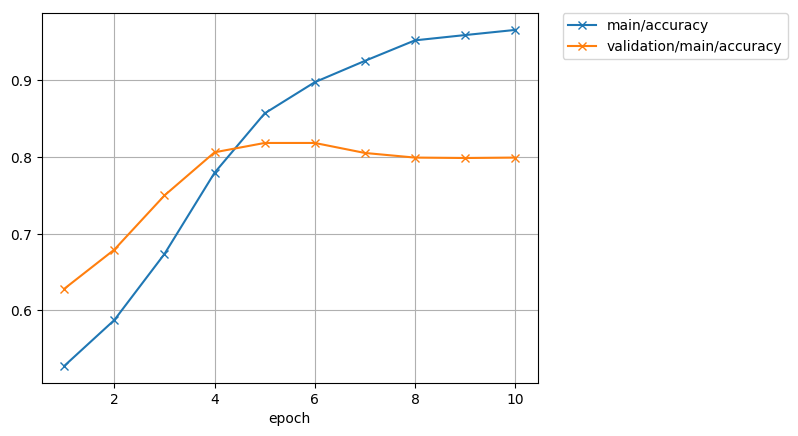

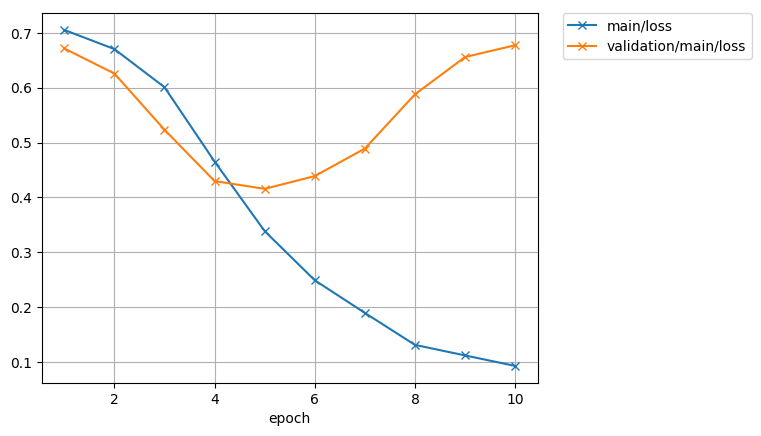

In [7]:
from IPython.display import Image
from IPython.display import display

accuracy_graph = Image(filename = "output/sentiment/accuracy.png", width=800, height=800)
loss_graph = Image(filename = "output/sentiment/loss.png", width=800, height=800)

display(accuracy_graph, loss_graph)

## Deploying the Trained Model

After training, we use the Chainer estimator object to create and deploy a hosted prediction endpoint. We can use a CPU-based instance for inference (in this case an `ml.m4.xlarge`), even though we trained on GPU instances.

The predictor object returned by `deploy` lets us call the new endpoint and perform inference on our sample images.

At the end of training, `sentiment_analysis.py` saves the trained model, the vocabulary, and a dictionary of model properties that are used to reconstruct the model. These model artifacts are loaded in `model_fn` when the model is hosted.

In [8]:
predictor = chainer_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-chainer-2018-05-18-22-07-42-787
INFO:sagemaker:Creating endpoint with name sagemaker-chainer-2018-05-18-22-07-42-787


--------------------------------------------------!

## Predicting using SageMaker Endpoint

The Chainer predictor converts its input into a NumPy array, which it serializes and sends to the hosted model.
The `predict_fn` in `sentiment_analysis.py` receives this NumPy array and uses the loaded model to make predictions on the input data, which it returns as a NumPy array back to the Chainer predictor.

We predict against the hosted model on a batch of sentences. The output, as defined by `predict_fn`, consists of the processed input sentence, the prediction, and the score for that prediction.

In [9]:
sentences = ['It is fun and easy to train Chainer models on Amazon SageMaker!',
             'It used to be slow, difficult, and laborious to train and deploy a model to production.',
             'But now it is super fast to deploy to production. And I love it when my model generalizes!',]
predictions = predictor.predict(sentences)
for prediction in predictions:
    sentence, prediction, score = prediction
    print('sentence: {}\nprediction: {}\nscore: {}\n'.format(sentence, prediction, score))

sentence: it is fun and easy to train chainer models on amazon sagemaker!
prediction: 1
score: 0.9935611486434937

sentence: it used to be slow, difficult, and laborious to train and deploy a model to production.
prediction: 0
score: 0.7134127616882324

sentence: but now it is super fast to deploy to production. and i love it when my model generalizes!
prediction: 1
score: 0.8182863593101501



We now predict against sentences in the test set:

In [10]:
with open(file_paths[1], 'r') as f:
    sentences = f.readlines(2000)
    sentences = [sentence[1:].strip() for sentence in sentences]
    predictions = predictor.predict(sentences)

predictions = predictor.predict(sentences)

for prediction in predictions:
    sentence, prediction, score = prediction
    print('sentence: {}\nprediction: {}\nscore: {}\n'.format(sentence, prediction, score))
    

sentence: no movement , no yuks , not much of anything .
prediction: 0
score: 0.9510830640792847

sentence: a gob of drivel so sickly sweet , even the eager consumers of moore 's pasteurized ditties will retch it up like rancid crème brûlée .
prediction: 0
score: 0.6786215305328369

sentence: gangs of new york is an unapologetic mess , whose only saving grace is that it ends by blowing just about everything up .
prediction: 0
score: 0.9286450743675232

sentence: we never really feel involved with the story , as all of its ideas remain just that : abstract ideas .
prediction: 0
score: 0.829836905002594

sentence: this is one of polanski 's best films .
prediction: 1
score: 0.9882621169090271

sentence: take care of my cat offers a refreshingly different slice of asian cinema .
prediction: 1
score: 0.9991244673728943

sentence: acting , particularly by tambor , almost makes `` never again '' worthwhile , but -lrb- writer\/director -rrb- schaeffer should follow his titular advice
predicti

## Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [11]:
chainer_estimator.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: sagemaker-chainer-2018-05-18-22-07-42-787
